In [1]:
import sys
import os
import polars as pl
import numpy as np
import sympy as sp
# Add the project root directory to PYTHONPATH
project_root = os.path.abspath(os.path.join(os.getcwd(), '..', 'src'))
sys.path.insert(0, project_root)

# Import necessary modules
import groundinsight as gi
from groundinsight.models.core_models import BusType, BranchType




# Generate Formulas for Grounding Elements
## Ring Surface Grounding
One typical example could be a ring around a building or a MV/LV substation with an addtional grounding rod. 
The formulas for each single grounding element: 

**Ring Grounding Element**
$$
R_S = \frac{\rho}{2\pi * D} * \log{\frac{2\pi D}{d}}
$$

**Rod Grounding Element**

$$
R_R = \frac{\rho}{2\pi * l} * \log{\frac{4*l}{d}}
$$

The effective grounding resistance can be calculated as the parallel circuiert of both elements: 

$$
R_G = \frac{R_S \cdot R_R}{R_S + R_R}
$$

To make it as simple as possible the package *sympy* can help to make a single string expression that we can use for the BusTypes

In [2]:
def par(a,b):
    return a*b/(a+b)

rho, pi = sp.symbols('rho pi')

#calculate the formula for ring grounding 
#diameter = 8 meters
#width = 0.02 meters
expr1 = (rho / (2 * pi**2 * 8) *sp.log(2*pi*8/0.02))

#formula for a single grounding rod 
#length = 5 meters
#width = 0.02 meters
expr2 = (rho / (2*pi*5)*sp.log(4*5/0.02))

expr = par(expr1, expr2)
print(f"Parallel circuit formula: {str(sp.simplify(expr))}")

#calculate the formula for a meshed grounding grid
#mesh = 100 * 100 meters
#meshsize = 10 meters
#whole line length = 2200 meters

b = 100
l = 100
lges = 2200
D = sp.sqrt(4*b*l/pi)

expr = rho /(2*D) + rho/lges
print(f"Formula for a specific grounding mesh: {str(sp.simplify(expr))}")

Parallel circuit formula: 0.690775527898214*rho*(log(pi) + 6.68461172766793)/(pi*(11.0524084463714*pi + log(pi) + 6.68461172766793))
Formula for a specific grounding mesh: rho/2200 + rho/(400*sqrt(1/pi))


In [3]:

#Test the calculation formula of the impedance
# Create a network
net = gi.create_network(name="SmallLowVoltage", frequencies=[50, 250, 350])
net.description = "A network of a small village with low voltage cables"

bus_type_prim_source = BusType(
    name="PrimarySource",
    description="A substation bus 110/20kV",
    system_type="Substation",
    voltage_level=110,
    impedance_formula="rho/2200 + rho/(400*sqrt(1/pi))"
)

bus_type_house = BusType(
    name="StandardHouse",
    description="Assumption of a standard family house with diameter of 10m",
    system_type="Building",
    voltage_level=0.4,
    impedance_formula="rho / (2 * pi**2 * 10) *log(2*pi*10/0.01)"
)

bus_type_station = BusType(
    name="StandardStation",
    description="A standard transformer station 20/0.4kV with a ring grounding system of 8m diameter and 1 rod with the length of 5m",
    system_type="Substation",
    voltage_level=20,
    impedance_formula="0.690775527898214*rho*(log(pi) + 6.68461172766793)/(pi*(11.0524084463714*pi + log(pi) + 6.68461172766793))",
)

bus_type_riser = BusType(
    name="StandardRiser",
    description="A standard riser with a ring grounding system of 4m diameter",
    system_type="Tower",
    voltage_level=20,
    impedance_formula="rho / (2 * pi**2 * 4) *log(2*pi*4/0.01)"
)

self_impedance_formula_nayy = "(0.201/1000 + (2*pi*f * 4*pi*10**(-7) / 8) + 1j * (2*pi*f * 4*pi*10**(-7) / (2 * pi)) * log((1.8514 / sqrt(2 * pi * f * 4*pi*10**(-7) / rho)) / (5.5/1000)))*l"
mutual_impedance_formula_nayy = "((2*pi*f * 4*pi*10**(-7) / 8) + 1j * (2*pi*f * 4*pi*10**(-7) / (2 * pi)) * log((1.8514 / sqrt(2 * pi * f * 4*pi*10**(-7) / rho)) / (5.5/1000)))*l"

self_impedance_formula_vpe = "(0.25/1000 + 3*(2*pi*f * 4*pi*10**(-7) / 8) + 1j * 3*(2*pi*f * 4*pi*10**(-7) / (2 * pi)) * log((1.8514 / sqrt(2 * pi * f * 4*pi*10**(-7) / rho)) / (0.040**2 * 0.035)**(1/3)))*l"
mutual_impedance_formula_vpe = "(3*(2*pi*f * 4*pi*10**(-7) / 8) + 1j * 3*(2*pi*f * 4*pi*10**(-7) / (2 * pi)) * log((1.8514 / sqrt(2 * pi * f * 4*pi*10**(-7) / rho)) / (0.040**2 * 0.035)**(1/3)))*l"



branch_type_nayy = BranchType(
    name="NAYY150",
    description="NAYY 150mm2 cable with PEN",
    grounding_conductor=True,
    self_impedance_formula=self_impedance_formula_nayy,
    mutual_impedance_formula=mutual_impedance_formula_nayy
)

branch_type_ohl = BranchType(
    name="Overheadline",
    description="Overheadline without grounding wire",
    grounding_conductor=False,
    self_impedance_formula="NaN",
    mutual_impedance_formula="NaN"
)

branch_type_vpe = BranchType(
    name="20_kV_VPE",
    description="20kV VPE cable with shield",
    grounding_conductor=True,
    self_impedance_formula=self_impedance_formula_vpe,
    mutual_impedance_formula=mutual_impedance_formula_vpe
)

#global resistivity
rho = 50


#create a remote bus for the current source
gi.create_bus(name="bus_remote", type=bus_type_prim_source, network=net, specific_earth_resistance=rho)

#insert a bus between remote and transformer station
gi.create_bus(name="bus_riser", type=bus_type_riser, network=net, specific_earth_resistance=rho)

#createa bus for the transformer station
gi.create_bus(name="bus_transformer", type=bus_type_station, network=net, specific_earth_resistance=rho)

#create a string of buses for the houses
num_buses = 5
for i in range(num_buses):
    gi.create_bus(name=f"bus_house{i}", type=bus_type_house, network=net, specific_earth_resistance=rho)

#create a second string of buses for the houses
for i in range(num_buses):
    gi.create_bus(name=f"bus_house2{i}", type=bus_type_house, network=net, specific_earth_resistance=rho)

#create a branch for the mv network
gi.create_branch(name="branch_remote_riser", type=branch_type_ohl, from_bus="bus_remote", to_bus="bus_riser", length=2000, network=net)

#create a branch for the transformer station
gi.create_branch(name="branch_transformer", type=branch_type_vpe, from_bus="bus_riser", to_bus="bus_transformer", length=300, network=net)

#connect string 1 with each house
for i in range(num_buses-1):
    gi.create_branch(name=f"branch_house{i}", type=branch_type_nayy, from_bus=f"bus_house{i}", to_bus=f"bus_house{i+1}", length=200, network=net)

#connect string 2 with each house
for i in range(num_buses-1):
    gi.create_branch(name=f"branch_house2{i}", type=branch_type_nayy, from_bus=f"bus_house2{i}", to_bus=f"bus_house2{i+1}", length=200, network=net)

#connect house 0 for each string with the transformer
gi.create_branch(name="branch_house_transformer", type=branch_type_nayy, from_bus="bus_transformer", to_bus="bus_house0", length=300, network=net)
gi.create_branch(name="branch_house2_transformer", type=branch_type_nayy, from_bus="bus_transformer", to_bus="bus_house20", length=300, network=net)

#create a faults
fault_scalings = {50:1, 250:1}
gi.create_fault(name="fault1", bus="bus_riser", scalings=fault_scalings, network=net)
gi.create_fault(name="fault2", bus="bus_transformer", scalings=fault_scalings, network=net)

#add a source at bus1
source = gi.create_source(name="source1", bus="bus_remote", values={50:30, 250:30, 350:30}, network=net)

#define the paths of the network
gi.create_paths(network=net)
fault_name = "fault1"
gi.run_fault(network=net, fault_name=fault_name)
results = net.results.get(fault_name)
print(results.grounding_impedance.value)



{50.0: (0.44456582450915827+0.605292380035054j), 250.0: (1.6559030677002395+1.7635579250822346j), 350.0: (2.185808076940646+1.9167745848564062j)}


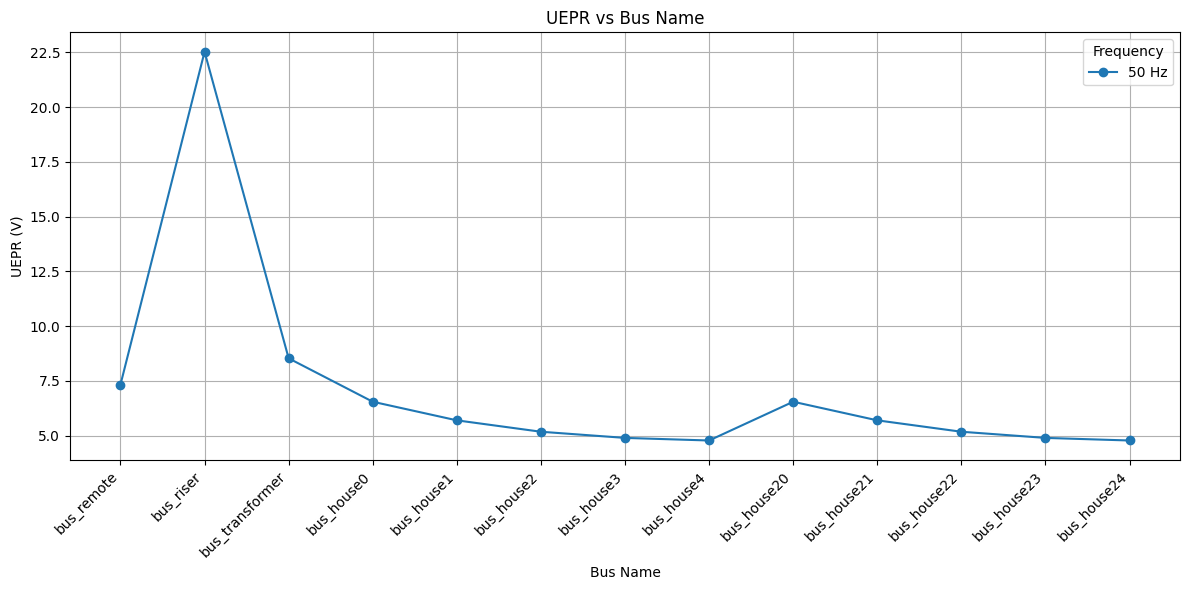

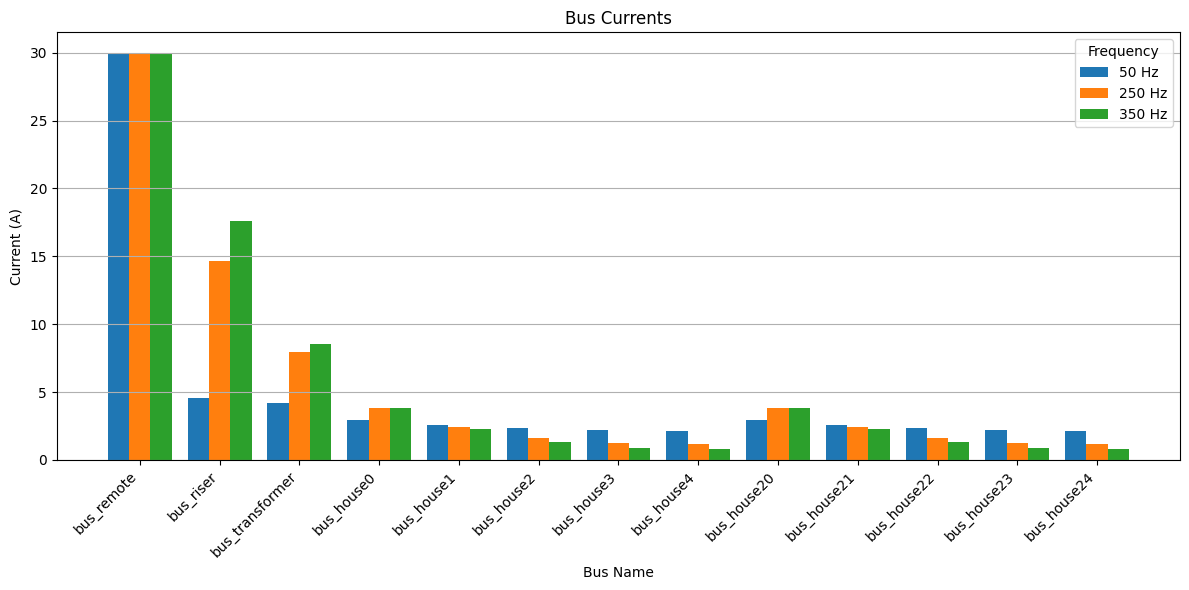

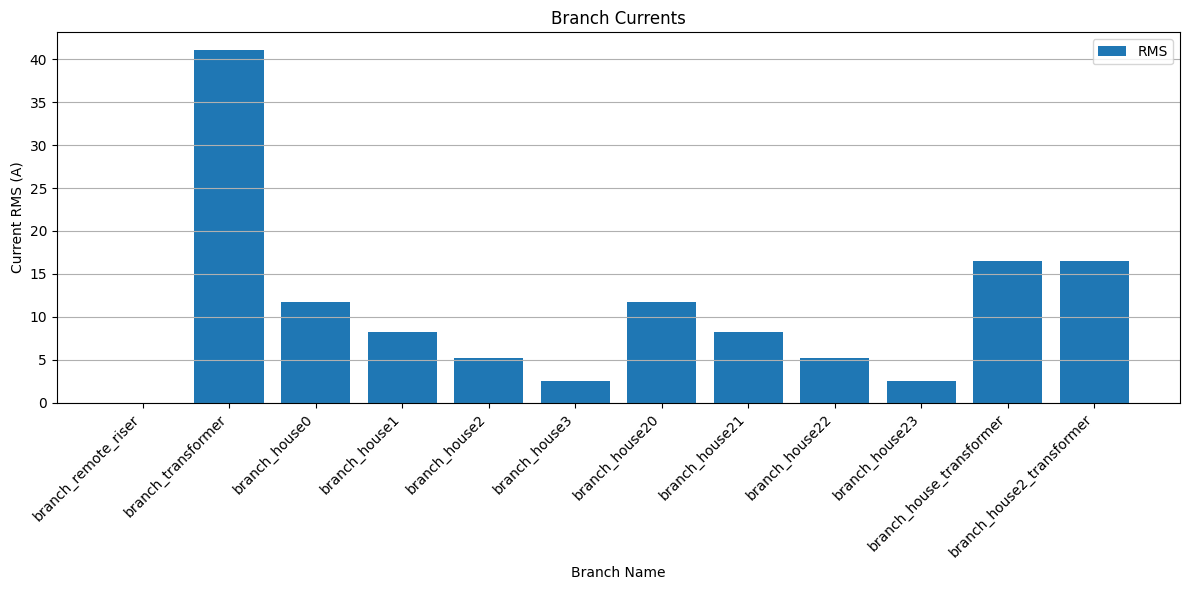

In [118]:
#plot the results for the fault in the transformer station
gi.plot_bus_voltages(results, frequencies=[50]);
gi.plot_bus_currents(results, frequencies=[50, 250, 350]);
gi.plot_branch_currents(results);